## Softmax操作
我们将在此处采用的主要方法是将模型的输出解释为概率。我们将优化参数以产生使观察到的数据的可能性最大化的概率。然后，为了生成预测，我们将设置一个阈值，例如，选择具有最大预测概率的标签。

正式地说，我们想要任何输出   $\hat{y}_j$  被解释为给定项目属于类别的概率  j 。然后我们可以选择具有最大输出值的类别作为我们的预测 $\operatorname*{argmax}_j y_j$. 。例如，如果  $\hat{y}_1$, $\hat{y}_2$, 和 $\hat{y}_3$ 分别为0.1、0.8和0.1。然后预测是第二类。

您可能会倾向于建议我们解释日志  o  直接作为我们感兴趣的输出。然而，将线性层的输出直接解释为概率存在一些问题。一方面，没有什么约束这些数字的总和为1。另一方面，取决于输入，它们可以取负值。

为了将我们的输出解释为概率，我们必须保证（即使在新数据上）它们也将是非负的并且总和为1。此外，我们需要一个训练目标来鼓励模型忠实地估计概率。在分类器输出0.5的所有实例中，我们希望这些示例中的一半实际上属于预测类。这是一个称为校准的属性。

社会科学家R.Duncan Luce在选择模型的背景下于1959年发明的softmax函数正好做到了这一点。为了使logit变为非负数且总和为1，同时要求模型保持可微性，我们首先对每个logit求幂（确保非负数），然后除以它们的总和（确保它们总和为1）：
$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{where}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}. $$
 
很容易看到  $\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$  与  $0 \leq \hat{y}_j \leq 1$ 对所有人 $j$ 。从而，  $\hat{\mathbf{y}}$ 是适当的概率分布，其元素值可以相应地解释。请注意，softmax操作不会更改登录之间的顺序  o ，它们只是确定分配给每个类别的概率的$softmax$之前的值。因此，在预测过程中，我们仍然可以通过

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$
 
尽管softmax是非线性函数，但softmax回归的输出仍由输入特征的仿射变换确定；因此，softmax回归是线性模型。

## 获取图像分类数据集
MNIST数据集是一种广泛使用的图像分类数据集，由于比较简单，不适合区分模型强弱，因此这里使用相对复杂的Fashion-MNIST数据集。

In [1]:
from d2l import mxnet as d2l
from mxnet import gluon
import sys
%matplotlib inline

d2l.use_svg_display()

### 从网络获取数据集
通过内置api获取数据，并读取放到内存中,Fashion-MNIST由10个类别的图像组成，每个类别由训练数据集中的6000张图像和测试数据集中的1000张图像表示。甲 测试数据集（或测试集）被用于评估模型的性能，而不是为了培训。因此，训练集和测试集分别包含60000和10000图像。

In [2]:
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
feature, label = mnist_train[0]

feature.shape, label

((28, 28, 1), 2)

Fashion-MNIST中的图像与以下类别相关联：T恤，裤子，套头衫，衣服，外套，凉鞋，衬衫，运动鞋，包和脚踝靴。通过label获取对应物品名称

In [5]:
def get_fashion_mnist_labels(labels): 
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

创建一个函数用来展示数据集图片的样子

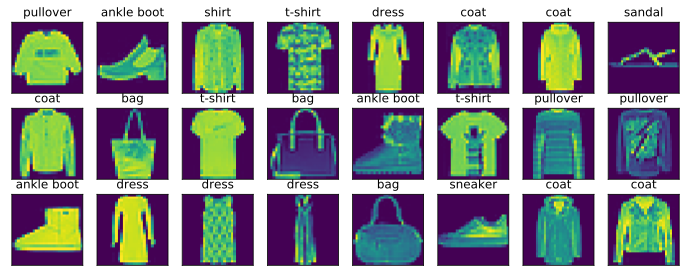

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 

    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(d2l.numpy(img))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
            
    return axes

X, y = mnist_train[:24]
show_images(X.squeeze(axis=-1), 3, 8, titles=get_fashion_mnist_labels(y));

为了使我们在阅读培训和测试集时更轻松，我们使用内置的数据迭代器，而不是从头开始创建迭代器。
+ ToTensor将图像数据从uint8转换为32位浮点
+ 将所有数字除以255，以便所有像素值都在0到1之间

In [7]:
batch_size = 256

def get_workers(num):
    # windows系统不能使用多线程转换
    return 0 if sys.platform.startswith('win') else num

transformer = gluon.data.vision.transforms.ToTensor()

train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                   batch_size, shuffle=True,
                                   num_workers=get_workers(6))

编写一个函数生成train和test的迭代器

In [8]:

def loader(data, batch_size, shuffle=True, workers = 6):
    return gluon.data.DataLoader(data,batch_size, shuffle=shuffle,
                                   num_workers=get_workers(workers))

def load_data(batch_size, resize=None):
    
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize else []
    trans.append(dataset.transforms.ToTensor())
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return loader(mnist_train, batch_size), loader(mnist_test, batch_size, False)    

In [9]:
train_iter, test_iter = load_data(32, resize=64)

In [10]:
for X, y in train_iter:
    print(X.shape, X.dtype, y.size, y.dtype)
    break

(32, 1, 64, 64) <class 'numpy.float32'> 32 <class 'numpy.int32'>


## 实现softmax回归

In [11]:
from mxnet import autograd, np, npx, gluon
from IPython import display
npx.set_np()

通过上面完成的方程实现数据集

In [12]:
batch_size = 256
train_iter, test_iter = load_data(batch_size)

### 初始化参数
由于图片是1X28X28大小的图片，展平图像将其看做是产度为28x28=784的向量，因此输入数量为784，因为分类的种类为10类，因此输出数量为10。
因此这里的权重为一个784x10的矩阵，偏差为1x10的向量。初始化权重和偏差，并创建梯度

In [13]:
num_inputs = 784
num_outputs = 10

W = np.random.normal(0, 0.02, (num_inputs, num_outputs))
b = np.zeros(num_outputs)
W.attach_grad()
b.attach_grad()

### 创建softmax函数
softmax包含三个步骤：
1. 我们对每个项求幂（使用exp）；
2. 我们对每一行求和（批处理中每个示例有一行）以获取每个示例的归一化常数；
3. 我们将每一行除以其归一化常数，确保结果总和为1。

In [14]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition # 求占比

### 定义模型
现在我们已经定义了softmax运算，我们可以实现softmax回归模型。因为我们定义的权重是一个784的向量，因此在计算之前需要把图片reshape成784的向量

In [15]:
def net(X):
    return softmax(np.dot(X.reshape((-1, W.shape[0])), W) + b)

### 定义损失函数
分类问题使用交叉熵损失函数，交叉熵采用分配给真实标签的预测概率的负对数似然性

In [16]:
def cross_entropy(y_hat, y):
    return - np.log(y_hat[range(len(y_hat)), y])

### 准确率
我们用于argmax通过每一行中最大条目的索引来获取预测类。我们将预测类别与基本事实y逐一进行比较。由于相等运算符 ==对数据类型敏感，因此我们将y_hat的数据类型转换为与匹配y。结果是一个张量，其中包含0（假）和1（真）条目。求和得出正确的预测数。

In [17]:
def accuracy(y_hat, y): 
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y
    return float(d2l.reduce_sum(cmp))

In [18]:
def evaluate_accuracy(net, data_iter):  

    match_num = total_num = 0
    for _, (X, y) in enumerate(data_iter):
        match_num += accuracy(net(X), y)
        total_num += y.size
    return match_num / total_num

In [19]:
evaluate_accuracy(net, test_iter)

0.0811

### 定义优化函数
优化函数为随机梯度下降来优化学习速率为0.1

In [20]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

### 训练
定义一个函数用来进行训练，这updater是更新模型参数的常规函数，该函数接受批次大小作为参数，它可以是d2l.sgd函数的包装器，也可以是框架的内置优化函数。

In [21]:
def train_epoch(net, train_iter, loss, updater):
    
    l_sum = acc_rate = total = 0
    
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
        
    for X,y in train_iter:
        with autograd.record():
            pre_y = net(X)
            l = loss(pre_y, y)
        l.backward()
        updater(y.size)
        l_sum += float(l.sum())
        acc_rate += accuracy(pre_y, y)
        total += y.size
    return l_sum/total, acc_rate/total
        

In [22]:
def train(net, train_iter, test_iter, loss, epochs, updater):
    l_lst = []
    acc_lst = []
    test_acc_lst = []
    for epoch in range(epochs):
        l, acc = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        l_lst.append(l)
        acc_lst.append(acc)
        test_acc_lst.append(test_acc)
    assert l < 0.5, l
    assert acc <= 1 and acc > 0.7, acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    return [l_lst, acc_lst, test_acc_lst]

In [23]:
num_epochs = 10
result = train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 可视化数据
使用plotly，将loss，准确率通过线图展现出来可以很好的观察变化

In [24]:
from plotly.offline import plot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

def draw_graph(result):
    data = []
    colors = ['aquamarine', 'orange', 'hotpink']
    names = ['train loss', 'train acc', 'test acc']
    symbols = ['circle-open', 'cross-open', 'triangle-up-open']
    for i, info in enumerate(result):
        trace = go.Scatter(
            x = list(range(1, num_epochs+1)),
            y = info,
            mode = 'lines+markers',
            name = names[i],
            marker = {
                'color':colors[i],
                'symbol':symbols[i],
            },
        )
        data.append(trace)
    fig = go.Figure(data = data)
    fig.show()

draw_graph(result)

### 预测
训练完成的模型通过输入一些数据进行预测，试试效果

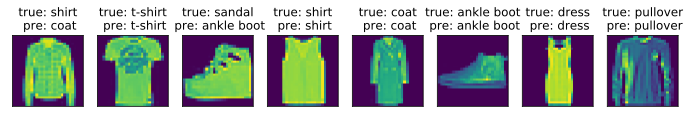

In [32]:
def predict(net, test_iter, stop, n=8):
    for i,(X,y) in enumerate(test_iter):
        if (i==stop) :
            break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(d2l.argmax(net(X), axis=1))
    titles = [f"true: {t}\n pre: {p}" for t, p in zip(trues, preds)]
    show_images(d2l.reshape(X[:n], (-1, 28, 28)), 1, n, titles=titles[:n])

import random
stop = random.choice(range(10))
predict(net, test_iter, stop)

## 简化
通过使用d2l以及gluon进行简化

### 数据
直接通过d2l包的load_data_fashion_mnist函数获取fashion_mnist数据集

In [26]:
from d2l import mxnet as d2l
from mxnet import gluon, init, npx
from mxnet.gluon import nn
npx.set_np()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 创建模型
softmax回归的输出层是完全连接的层，因为10种类型这里需要10个输出，我们以零均值和标准差0.01随机初始化权重。

In [27]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

### 损失函数
使用分类用的交叉熵损失函数

In [28]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

### 优化函数
使用学习速度为0.1的小批量随机梯度下降作为优化算法

In [29]:
trainer = gluon.Trainer(params=net.collect_params(), optimizer='SGD', optimizer_params={'learning_rate': 0.1})

### 训练
使用上面的训练模型进行训练

In [30]:
num_epochs = 10
result = train(net, train_iter, test_iter, loss, num_epochs, trainer)
draw_graph(result)